# Importing Python Packages and Data

In [197]:
# Import everything needed

import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import matplotlib
import matplotlib.collections

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import precision_recall_curve

matplotlib.rcParams['font.family'] = ['arial']

In [198]:
total_data = pd.read_csv("cleaned_data.dbcan_cog_HGT.tsv", sep="\t")
total_data = total_data.drop(columns = ['Unnamed: 0'])

In [226]:
print(total_data.shape)
total_data.head()

(3772, 4564)


,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


In [227]:
# Removing soil! Separating PA and NPA!

df = total_data[total_data["Classification"] != "soil"]
print(df.shape)
order = df['Order']
df.head()

(3261, 4564)


,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


# Data Preprocessing and Feature Selection, all models

In [228]:
# Scaling data with Standard Scaler, code from Muyoung

features = df.columns[4:]
scaler = StandardScaler().fit(df[features])
df_normalized = pd.DataFrame(scaler.transform(df[features]), columns=features)
df = pd.concat([df.iloc[:, :4], df_normalized], axis=1)
df.head()

,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
1,2519103115,Acinetobacter,NPA,NPA,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.313281
2,2519899735,Acinetobacter,NPA,NPA,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
3,2526164562,Acinetobacter,NPA,NPA,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.218343
4,2529293005,Acinetobacter,NPA,NPA,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.294080


In [229]:
# Removing features with zero variance, code from Muyoung 

constant_filter = VarianceThreshold(threshold=0) 
constant_filter.fit(df[features])
features = constant_filter.get_feature_names_out(features)

X = df[features]
y = df["Classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Principal Component Analysis

In [230]:
# Actually doing the PCA

pca = decomposition.PCA(n_components=2)

pca_result = pca.fit_transform(X)

# Making labels for plotting the graph

labels = y.ravel()

for idx, val in enumerate(labels):
    if val == "NPA":
        labels[idx] = 0
    elif val == "PA":
        labels[idx] = 1
    else:
        print("Error!")

x_plot = pca_result[:,0]
y_plot = pca_result[:,1]

NPA


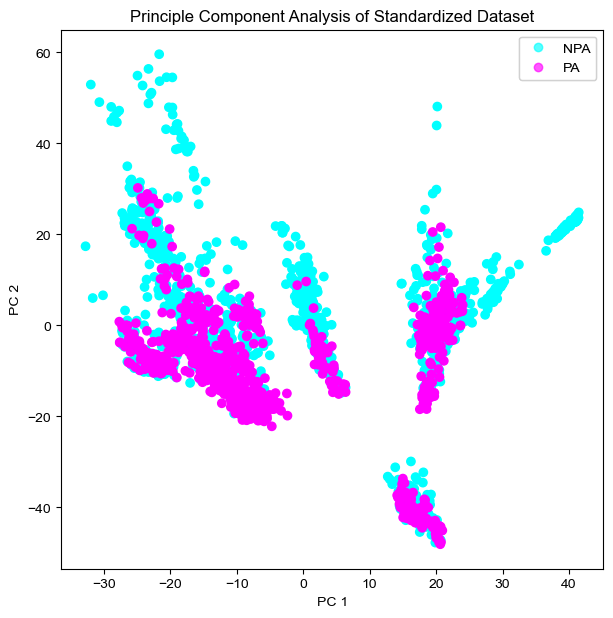

In [236]:
# Plotting by classification

fig, ax = plt.subplots(1, figsize = (7,7))

scatter1 = ax.scatter(x_plot,y_plot, c = labels, cmap = "cool")
handles, _ = scatter1.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = ax.legend(handles, ["NPA", "PA"], loc="upper right")
ax.add_artist(legend1)

pca_result = pd.DataFrame(pca_result)
    
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Principle Component Analysis of Standardized Dataset")
plt.savefig("PCA_SDS_Final_Project.svg")
plt.show()

In [205]:
# This block of code deals with making bacterial orders categorical, for PC visualization

orders = order.unique()
order_numeric = np.zeros((len(orders),1))

order_forplotting = order

for idx, val in enumerate(orders):
    #str_idx = str(idx)
    order_forplotting = order_forplotting.replace(str(val), idx)

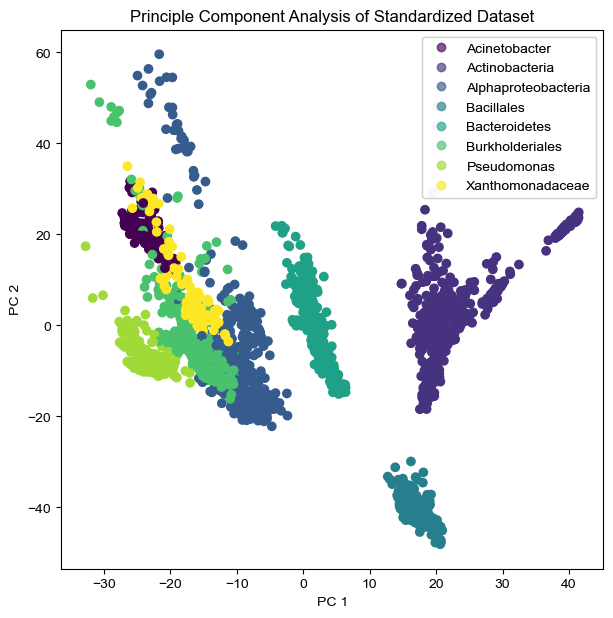

In [214]:
# Plotting by order

fig, ax = plt.subplots(1, figsize = (7,7))

scatter1 = ax.scatter(x_plot,y_plot, c = order_forplotting.ravel())
handles, _ = scatter1.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = ax.legend(handles, orders, loc="upper right")
ax.add_artist(legend1)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Principle Component Analysis of Standardized Dataset")
plt.savefig("PCA_SDS_Final_Project_Orders.svg")
plt.show()

In [166]:
labels.shape

(3261,)

In [104]:
dataset_pca = pd.DataFrame(abs(pca.components_),columns=X.columns, index=['PC_1', 'PC_2'])
dataset_pca.to_csv('PCA_of_Dataset.csv')

In [105]:
dataset_pca_t = dataset_pca.transpose()

In [239]:
dataset_pca_t.nlargest(20, "PC_1")

,PC_1,PC_2
COG0391,0.040889,0.010532
COG2138,0.040196,0.005190
COG0311,0.040104,0.001661
COG3480,0.040014,0.000795
COG1481,0.039897,0.001588
COG1799,0.039878,0.000782
CE14,0.039823,0.002809
COG3253,0.039497,0.001616
COG1837,0.039455,0.001910
COG3599,0.039155,0.011813


In [240]:
dataset_pca_t.nlargest(20, "PC_2")

,PC_1,PC_2
COG0321,0.007198,0.042216
COG0792,0.004132,0.040508
COG0539,0.005358,0.039709
COG1109,0.006386,0.039575
COG0726,0.003734,0.038774
COG0484,0.001025,0.038504
COG1678,0.012767,0.038162
COG0322,0.019579,0.038046
COG0221,0.007711,0.037873
COG0354,0.007046,0.037844


# Feature Selection

In [80]:
# https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
coef = model.coef_[0]

In [81]:
# Trimming features from the X dataset

imp_features = pd.Series(X.columns)[list(coef!=0)]
X_train = X_train[imp_features]
X_test = X_test[imp_features]
X = X[imp_features]

In [82]:
imp_features.to_csv('logistic_regression_features.csv', index=True, header=False)

In [83]:
imp_features.shape

(311,)

In [84]:
coef.shape

(4540,)

In [85]:
features.shape

(4540,)

# Data Visualization

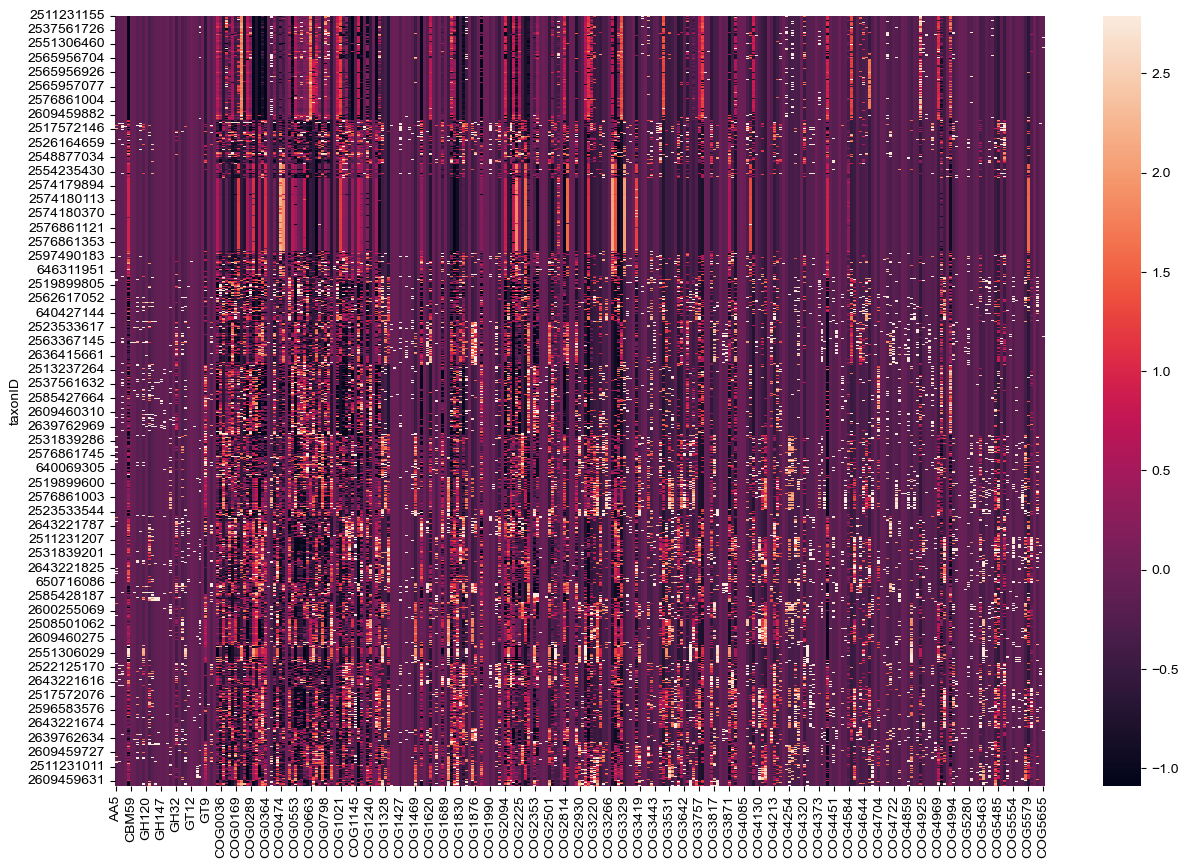

In [96]:
fig, ax = plt.subplots(figsize=(15,10))
X_forplotting = X
X_forplotting.index = df['taxonID']
ax = sb.heatmap(X_forplotting, robust = True) # square = True, 

# Model Training

## Logistic Regression, Three Penalties

In [173]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [174]:
clf_l1 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)
clf_l2 = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)
clf_en = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)

In [175]:
y_pred_l1 = clf_l1.predict_proba(X_test)
y_pred_l2 = clf_l2.predict_proba(X_test)
y_pred_en = clf_en.predict_proba(X_test)

In [176]:
clf_l1.score(X_train, y_train)

0.9958791208791209

In [177]:
clf_l2.score(X_train, y_train)

0.9986263736263736

In [178]:
clf_en.score(X_train, y_train)

0.9972527472527473

In [179]:
clf_l1.score(X_test, y_test)

0.8737233054781801

In [180]:
clf_l2.score(X_test, y_test)

0.8802228412256268

In [181]:
clf_en.score(X_test, y_test)

0.8792943361188487

In [182]:
precision_l1, recall_l1, thresholds_l1 = precision_recall_curve(y_test, y_pred_l1[:,0], pos_label = ["NPA"])
precision_l2, recall_l2, thresholds_l2 = precision_recall_curve(y_test, y_pred_l2[:,0], pos_label = ["NPA"])
precision_en, recall_en, thresholds_en = precision_recall_curve(y_test, y_pred_en[:,0], pos_label = ["NPA"])

[]

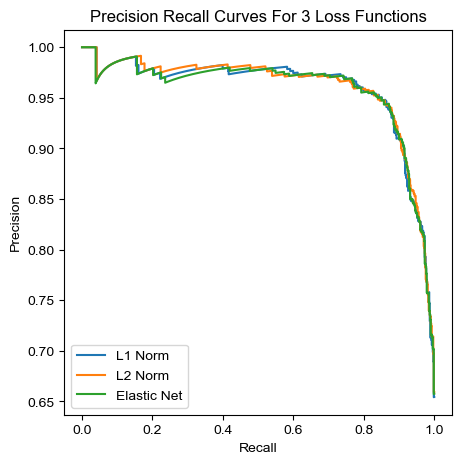

In [183]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_l1, precision_l1)
ax.plot(recall_l2, precision_l2)
ax.plot(recall_en, precision_en)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

## Support Vector Machine Classifier

In [198]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svc = SVC(gamma = 'auto', probability = True).fit(X_train, y_train)

In [199]:
clf_svc.score(X_train, y_train)

0.9844322344322345

In [200]:
clf_svc.score(X_test, y_test)

0.8960074280408542

In [201]:
y_pred_1 = clf_svc.predict_proba(X_test)

In [202]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

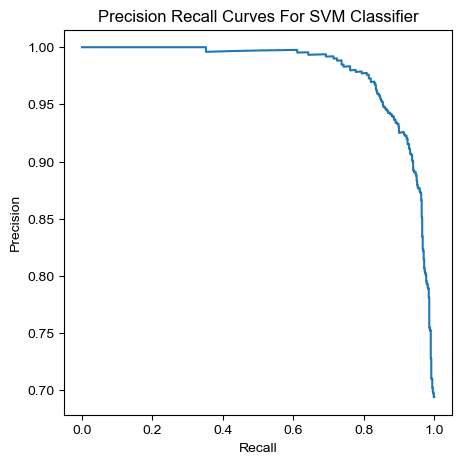

In [203]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For SVM Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

## Gaussian Naive Bayes Classifier

In [190]:
# https://scikit-learn.org/stable/modules/naive_bayes.html BAD AT PREDICTIONS

gnb = GaussianNB().fit(X_train,y_train)

In [191]:
y_pred = gnb.predict_proba(X_test)

In [192]:
gnb.score(X_train,y_train)

0.6831501831501832

In [193]:
gnb.score(X_test,y_test)

0.6527390900649953

In [194]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

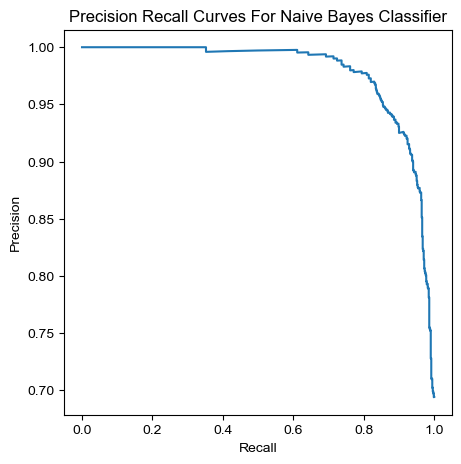

In [195]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For Naive Bayes Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

# Testing on Soil

In [197]:
df_soil = total_data[total_data["Classification"] == "soil"]
X_soil = df_soil[imp_features]

In [215]:
y_pred_l1_soil = clf_l1.predict(X_soil)
y_pred_l2_soil = clf_l2.predict(X_soil)
y_pred_en_soil = clf_en.predict(X_soil)
y_pred_svc_soil = clf_svc.predict(X_soil)
y_pred_gnb_soil = gnb.predict(X_soil)

In [209]:
X_soil.shape

(511, 310)

In [208]:
sum(y_pred_l1_soil == y_pred_l2_soil)

511

In [210]:
sum(y_pred_l1_soil == y_pred_en_soil)

511

In [211]:
sum(y_pred_l1_soil == y_pred_svc_soil)

511

In [216]:
sum(y_pred_l1_soil == y_pred_gnb_soil)

511

In [217]:
# All predictions are the same! This might be because my features are so small (only around 300)